In [1]:
!pip install sagemaker --upgrade

  Using cached sagemaker-2.72.0.tar.gz (477 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.72.0-py2.py3-none-any.whl size=649529 sha256=b87f643fe4706334cdce3780e9a35d62da5a13ba3206f4a58240e70d1bb355fb
  Stored in directory: /home/ec2-user/.cache/pip/wheels/28/00/08/3ae2578287670a327d582668ae2815d0ef4d4a534626540f42
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.70.0
    Uninstalling sagemaker-2.70.0:
      Successfully uninstalled sagemaker-2.70.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sagemaker.huggingface import HuggingFaceModel
import sagemaker

role = sagemaker.get_execution_role()
# Hub Model configuration. https://huggingface.co/models
hub = {
	'HF_MODEL_ID':'anelnurkayeva/autonlp-covid-432211280',
	'HF_TASK':'text-classification'
}

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
	transformers_version='4.6.1',
	pytorch_version='1.7.1',
	py_version='py36',
	env=hub,
	role=role, 
)
client = boto3.client('sagemaker-runtime')

# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
	initial_instance_count=1, # number of instances
    
	instance_type='ml.m5.xlarge' # ec2 instance type
)

predictor.predict({
	'inputs': "I like you. I love you"
})

----!

[{'label': 'news', 'score': 0.9483976364135742}]

In [5]:
import pandas as pd
df = pd.read_csv("test.csv")

In [6]:
df.head()

,Unnamed: 0,text,label,category,data_type
0,7,A video says weed kills coronavirus.\t\t,0,misleading,test
1,12,Coronavirus is caused by snakes.\t\t,0,misleading,test
2,17,Bill Gates predicted coronavirus.\t\t,0,misleading,test
3,19,"In 2012, a Facebook user predicted coronaviru...",0,misleading,test
4,23,A child from China has coronavirus in Galicia...,0,misleading,test
...,...,...,...,...,...
1617,512,Perhaps the biggest example of the Western med...,0,misleading,test
1618,513,"For the last 2 months, we've been wondering: w...",0,misleading,test
1619,521,In a February 2020 email between Dr. Anthony F...,0,misleading,test
1620,522,"A logistical ""roadmap"" from Shanghai Fosun Pha...",0,misleading,test


In [57]:
df['pred_label'] = 'news'
df['score'] = 1.0


In [126]:
df.category.value_counts()
    

news          1008
misleading     252
Name: category, dtype: int64

In [59]:
mydict=df.to_dict('records')

In [ ]:
  "parameters": {'truncation': True}

In [ ]:
for r in mydict:
    r['pred_label'] = predictor.predict({'inputs': r['text'],   "parameters": {'truncation': True}})[0]['label']
    r['score'] = predictor.predict({'inputs': r['text'],   "parameters": {'truncation': True}}   )[0]['score']


In [ ]:
df= pd.DataFrame(mydict)

In [77]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df['category'], df['pred_label'])

array([[226,  26],
       [ 21, 987]])

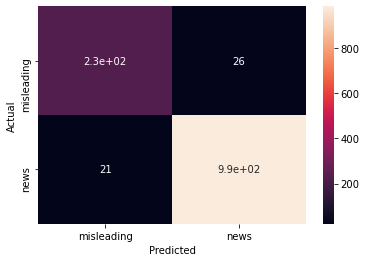

In [115]:
import seaborn as sn
import matplotlib.pyplot as plt
confusion_matrix = pd.crosstab(df['category'], df['pred_label'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [116]:
from sklearn.metrics import accuracy_score
accuracy_score(df['category'], df['pred_label'])

0.9626984126984127

In [117]:
from sklearn.metrics import f1_score
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
y_true = lb.fit_transform(df['category'])
lb = preprocessing.LabelBinarizer()
y_pred = lb.fit_transform(df['pred_label'])

f1_score(y_true, y_pred)

0.9767441860465116

In [118]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average='macro')

0.9379960317460317

In [119]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average='macro')

0.944656709736982

In [120]:
probas = df['score']
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]

In [123]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average='macro')

0.944656709736982

In [121]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(df['category'], df['score'], pos_label=['news'], sample_weight=None, drop_intermediate=True)

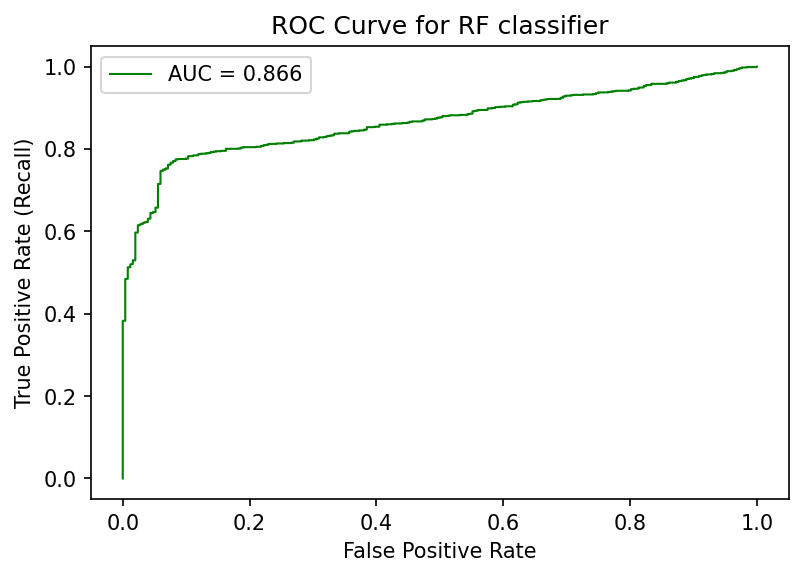

In [122]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# get area under the curve
roc_auc = auc(fpr, tpr)
# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
plt.title('ROC Curve for RF classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()